In [ ]:
# !pip install --upgrade --no-cache-dir gdown

In [ ]:
# !pip install tensorflow

In [ ]:
# !unzip -oq bank_notes.zip

In [ ]:
# !python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

In [2]:
import tensorflow as tf
tf.random.set_seed(40)

# training image
train_image_path = 'bank_notes/train'
IMG_SHAPE = 150
training_images =  tf.keras.utils.image_dataset_from_directory(train_image_path,
                                                               image_size=(IMG_SHAPE, IMG_SHAPE),
                                                               shuffle=True, seed = 0, batch_size = 64)

validation_image_path = 'bank_notes/valid'
validation_images =  tf.keras.utils.image_dataset_from_directory(validation_image_path,
                                                               image_size=(IMG_SHAPE, IMG_SHAPE),
                                                               shuffle=False, seed = 0, batch_size = 16
                                                               )

test_image_path = 'bank_notes/test'
test_images =  tf.keras.utils.image_dataset_from_directory(test_image_path,
                                                               image_size=(IMG_SHAPE, IMG_SHAPE),
                                                               shuffle=False,seed = 0, batch_size = 32
                                                               )

Found 6300 files belonging to 7 classes.
Found 2100 files belonging to 7 classes.
Found 1349 files belonging to 7 classes.


In [6]:
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomRotation(30),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomZoom(0.5)
])

In [7]:
train_images = training_images.map(lambda x, y: (data_augmentation(x), y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [8]:
import tensorflow as tf

data_rescale = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255)
])

In [9]:
validation_images = validation_images.map(lambda x, y: (data_rescale(x), y))

In [22]:
pre_trained_model = tf.keras.applications.inception_v3.InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = 'imagenet')


for layer in pre_trained_model.layers:
    layer.trainable = False
    

In [23]:
# pre_trained_model.summary()

In [24]:
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

In [25]:
model_check_point = tf.keras.callbacks.ModelCheckpoint('cashRec.h5', monitor='val_accuracy',save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping('val_loss', patience=5)
callbacks = [early_stop, model_check_point]

In [26]:
# Flatten the output layer to 1 dimension
x = tf.keras.layers.GlobalAveragePooling2D()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = tf.keras.layers.Dropout(0.3)(x) 

x = tf.keras.layers.Dense(49, activation='relu')(x)
# Add a final sigmoid layer for classification
x = tf.keras.layers.Dense  (7, activation='softmax')(x)           

model = tf.keras.Model(pre_trained_model.input, x) 

model.compile(optimizer = 'adam', 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

In [27]:
history = model.fit(
            train_images,
            validation_data = validation_images,
            epochs = 20,
            verbose = 1, callbacks = callbacks)

Epoch 1/20
99/99 [==============================] - 89s 857ms/step - loss: 0.9777 - accuracy: 0.6843 - val_loss: 0.4413 - val_accuracy: 0.8714
Epoch 2/20
99/99 [==============================] - 84s 840ms/step - loss: 0.3660 - accuracy: 0.8867 - val_loss: 0.3891 - val_accuracy: 0.8571
Epoch 3/20
99/99 [==============================] - 85s 851ms/step - loss: 0.2564 - accuracy: 0.9198 - val_loss: 0.2714 - val_accuracy: 0.9062
Epoch 4/20
99/99 [==============================] - 83s 838ms/step - loss: 0.1974 - accuracy: 0.9368 - val_loss: 0.3274 - val_accuracy: 0.8829
Epoch 5/20
99/99 [==============================] - 84s 840ms/step - loss: 0.2005 - accuracy: 0.9327 - val_loss: 0.2958 - val_accuracy: 0.8881
Epoch 6/20
99/99 [==============================] - 85s 847ms/step - loss: 0.1946 - accuracy: 0.9316 - val_loss: 0.2533 - val_accuracy: 0.9167
Epoch 7/20
99/99 [==============================] - 83s 836ms/step - loss: 0.1521 - accuracy: 0.9479 - val_loss: 0.2508 - val_accuracy: 0.9090

In [28]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

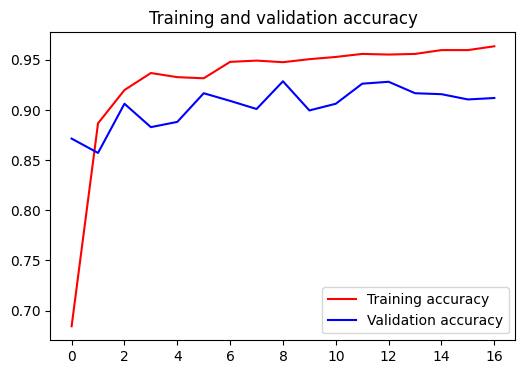

In [29]:
plt.figure(figsize=(6,4))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('train_val_acc.png', dpi = 400)
plt.show()

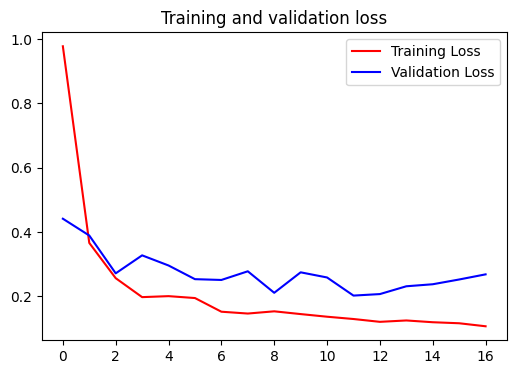

In [30]:
plt.figure(figsize=(6,4))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('train_val_loss.png', dpi = 400)
plt.show()

In [33]:
model.save('cashRec.h5')

In [12]:
test_images_scaled = test_images.map(lambda x, y: (data_rescale(x), y))

In [13]:
import tensorflow as tf
model = tf.keras.models.load_model('cashRec.h5')

In [14]:
scores = model.evaluate(test_images_scaled)
print("%s%s: %.2f%%" % ("evaluate_generator ",model.metrics_names[1], scores[1]*100))

43/43 [==============================] - 13s 266ms/step - loss: 0.2088 - accuracy: 0.9303
evaluate_generator accuracy: 93.03%


In [15]:
import numpy as np
predictions = model.predict(test_images_scaled)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.concatenate([y for x, y in test_images], axis=0)

43/43 [==============================] - 13s 264ms/step


In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(true_labels, predicted_labels)

In [17]:
cm

array([[ 75,   0,   0,  18,   1,   0,   0],
       [  0,  75,   0,   0,   0,   0,   6],
       [  0,   1,  96,   1,   1,   2,   0],
       [  3,   0,   1, 362,   4,   1,   1],
       [  7,   4,   6,  12, 273,   7,   6],
       [  0,   0,   3,   3,   0,  97,   1],
       [  0,   0,   0,   4,   1,   0, 277]])

In [18]:
predicted_labels

array([0, 0, 0, ..., 6, 6, 6])

In [19]:
true_labels

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [20]:
test_images.class_names

['fifty', 'five', 'fivehundred', 'hundred', 'ten', 'thousand', 'twenty']

In [24]:
class_names = test_images.class_names

In [25]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (10,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi = 500)
    plt.show()

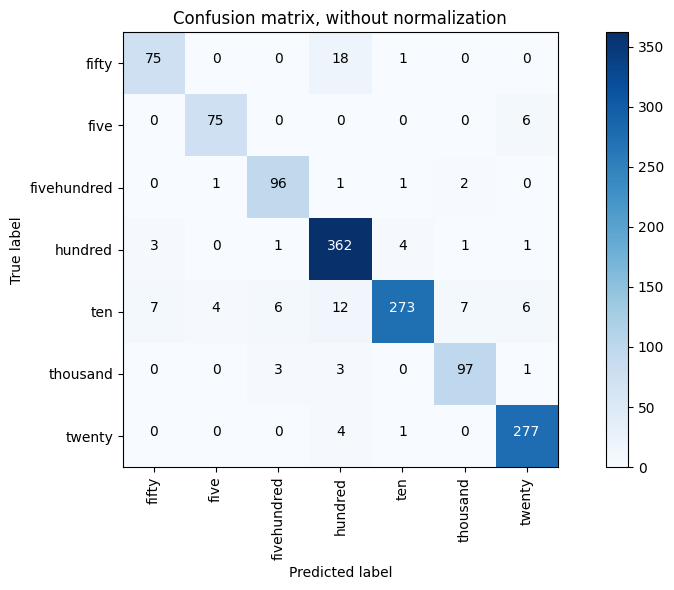

In [26]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix, without normalization')

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [28]:
precision = precision_score(true_labels, predicted_labels, average ='micro')
recall    = recall_score(true_labels, predicted_labels, average ='micro')
f1        = f1_score(true_labels, predicted_labels, average ='micro')

print(f"Precision = {round(precision * 100, 2)}%")
print(f"Recall = {round(recall * 100, 2)}%")
print(f"F1-score = {round(f1 * 100, 2)}%")

Precision = 93.03%
Recall = 93.03%
F1-score = 93.03%


In [45]:
!ls

'Cash recognition-final.ipynb'	 confusion-matrix.png	 train_val_loss.png
 bank_notes			 install_gpu_driver.py	 tutorials
 bank_notes.zip			 src
 cashRec.h5			 train_val_acc.png


In [76]:
%%bash
zip cashproj.zip cash-recognition-final.ipynb confusion-matrix.png train_val_loss.png cashRec.h5  train_val_acc.png 

	zip warning: name not matched: Cash
	zip warning: name not matched: recognition-final.ipynb
  adding: confusion-matrix.png (deflated 14%)
  adding: train_val_loss.png (deflated 18%)
  adding: cashRec.h5 (deflated 8%)
  adding: train_val_acc.png (deflated 17%)
